In [ ]:
from scr import *
pd.set_option('display.max_rows', None)

### dataset

1    53758
0    53758
Name: target, dtype: int64
Hay nulos? False
Filas, columnas: (107516, 5)


<AxesSubplot:xlabel='target', ylabel='count'>

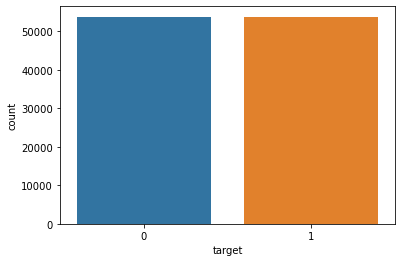

In [ ]:
dfr = pd.read_csv("df.csv")
dfr = dfr.drop("Unnamed: 0",axis=1)

df = dfr.copy()
df = df.drop(['Polarity','Sentiment'],axis=1)
df = df.rename(columns={'Tweets':'text','Encoding':'target'})
print(df.target.value_counts())
print("Hay nulos?", df.isnull().values.any())
print("Filas, columnas:", df.shape)
sns.countplot(x="target", data= df)

### pre proceso

In [ ]:
print("Limpiando los datos...")
df.text = df.text.apply(lambda x: clean_text(x))
print("Datos limpios: ")
print(df.head())

Limpiando los datos...
Datos limpios: 
          Day                   id  \
0  2022-09-10  1568741009739194368   
1  2022-09-10  1568745232933572614   
2  2022-09-07  1567655678180827137   
3  2022-09-15  1570554612977119232   
4  2022-09-11  1569109599281881089   

                                                user  \
0  {'username': 'jacobs_mati', 'id': 144076163596...   
1  {'username': 'Alfredo97782022', 'id': 15202202...   
2  {'username': 'ilvsagust', 'id': 13030652818294...   
3  {'username': 'Elixerily', 'id': 14097057941746...   
4  {'username': 'lorcat99', 'id': 819628445235875...   

                                                text  target  
0  en serio cree q lo volvere ver solo pq tiene s...       1  
1  jose ramon segun tu porque los usa engana con ...       1  
2            yo estoy hablando enserio solo ignorame       1  
3      amigo sabia que cashapp es solo para 2 paises       0  
4    creo q solo sirve para si se te pierde el movil       1  


### split de datos

In [ ]:
# split the data into train set (80%) and test set (20%)
train_size = 0.8
train_data, test_data = train_test_split(df, test_size = 1 - train_size, random_state = 0, stratify = df.target)
# how many examples of each class there is in each set
print("Train data distr:\n", train_data.target.value_counts())
print("Test data distr:\n", test_data.target.value_counts())

Train data distr:
 1    43006
0    43006
Name: target, dtype: int64
Test data distr:
 0    10752
1    10752
Name: target, dtype: int64


In [ ]:
# Ensure the encoder
encoder = LabelEncoder()
# enconde labels (0 or 1) in train data
encoder.fit(train_data.target.to_list())

# transform labels in y_train and y_test data to the encoded ones
y_train = encoder.transform(train_data.target.to_list())
y_test = encoder.transform(test_data.target.to_list())

# reshape y_train and y_test data
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

### tokenizer

In [ ]:
# create a tokenizer
tokenizer = Tokenizer()
# fit the tokenizer in the train text
tokenizer.fit_on_texts(train_data.text)
# save the tokenizer as a pickle to use it later in the testing part
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol = pickle.HIGHEST_PROTOCOL)

### padding

In [ ]:
# Getting the maximum length of the train data
max_length = max([len(s.split()) for s in train_data.text])

# pad sequences in x_train data set to the max length
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = max_length)
# pad sequences in x_test data set to the max length
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = max_length)

### word embeding modelo pre entrenado

In [ ]:
vocab = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300

print("Vocab size: ", vocab_size)
print("Max length: ", max_length)

Vocab size:  88071
Max length:  61


In [ ]:
# uso un modelo pre entrenado de word vectors en español
# que se llama SBW-vectors-300-min5 y tiene dim 300

embeddings_dictionary = dict()
glove_file = open('SBW.vectors.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
from keras.layers import LSTM
import tensorflow_addons as tfa
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)
f1 = tfa.metrics.F1Score(36,'micro' or 'macro')

model = Sequential()
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=61)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 61, 300)           26421300  
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 26,641,077
Trainable params: 26,641,077
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
start_time = datetime.now()

history = model.fit(x_train,
                    y_train,
                    batch_size=1024,
                    epochs=8,
                    validation_split=0.1,
                    verbose=1)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/8
76/76 [==============================] - 133s 2s/step - loss: 0.6114 - accuracy: 0.6588 - val_loss: 0.6642 - val_accuracy: 0.6042
Epoch 2/8
76/76 [==============================] - 147s 2s/step - loss: 0.5226 - accuracy: 0.7363 - val_loss: 0.7409 - val_accuracy: 0.5759
Epoch 3/8
76/76 [==============================] - 149s 2s/step - loss: 0.3780 - accuracy: 0.8279 - val_loss: 0.8785 - val_accuracy: 0.5759
Epoch 4/8
76/76 [==============================] - 149s 2s/step - loss: 0.2655 - accuracy: 0.8809 - val_loss: 1.0669 - val_accuracy: 0.5638
Epoch 5/8
76/76 [==============================] - 147s 2s/step - loss: 0.1948 - accuracy: 0.9120 - val_loss: 1.2882 - val_accuracy: 0.5584
Epoch 6/8
76/76 [==============================] - 154s 2s/step - loss: 0.1513 - accuracy: 0.9314 - val_loss: 1.5054 - val_accuracy: 0.5609
Epoch 7/8
76/76 [==============================] - 154s 2s/step - loss: 0.1233 - accuracy: 0.9437 - val_loss: 1.7541 - val_accuracy: 0.5603
Epoch 8/8
76/76 [===

In [ ]:
model.save('my_model.h5')
with open('pick_plantilla_fit8.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol = pickle.HIGHEST_PROTOCOL)

### testear el modelo

In [ ]:
score = model.evaluate(x_test, y_test, batch_size = 1024)
model.save('model_final_plantilla8.h5')

### model predict

In [ ]:
from keras.models import load_model

In [ ]:
# decode score prediction from the model, to be 0 or 1
def decode_prediction(prediction):
    return 'Negative' if prediction < 0.5 else 'Positive'

# load model
model = load_model('model_final_plantilla8.h5')
# loading tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
predictions_nn_train = model.predict(x_train)
predictions_nn_test = model.predict(x_test)
y_pred = np.around(model.predict(x_test))

672/672 [==============================] - 33s 50ms/step


In [ ]:
lista = ('matar','morir','suicidar','suicidarme','suicidio','pistola','ahorcar','muerto','muerte','deprimido', 'humillado','triste','sufrimiento','infeliz')

In [ ]:
since = '2022-09-21'
until = '2022-09-22'
max_tweets = 100
lista = lista

start_time = datetime.now()

predict = scraper(lista,max_tweets,since,until)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

predict.to_csv("predict.csv")
print("guardado")

Duration: 0:00:04.130527
guardado


In [ ]:
predict.drop(['url',
                  'renderedContent',
                  'replyCount',
                  'retweetCount',
                  'likeCount',
                  'quoteCount',
                  'conversationId',
                  'lang',
                  'source',
                  'sourceUrl',
                  'sourceLabel',
                  'links',
                  'media',
                  'retweetedTweet',
                  'quotedTweet',
                  'inReplyToTweetId',
                  'inReplyToUser',
                  'mentionedUsers',
                  'coordinates',
                  'place',
                  'hashtags',
                  'cashtags',
                  'card'
                 ],axis=1,inplace=True)

In [ ]:
predict = predict.rename({'rawContent':'Text'},axis=1)
df = predict.copy()

In [ ]:
x = range(100)
predict = []
lab = []
for tweet in df.Text:
    # clean query text
    input_text = clean_text(tweet)
    # tokenize and pad query test as in training
    input_text = pad_sequences(tokenizer.texts_to_sequences([input_text]),
                            maxlen = max_length)

    # get model prediction
    prediction = model.predict([input_text])[0]
    predict.append(prediction)
    # get decode prediction
    label = decode_prediction(prediction)
    lab.append(label)

numero_predict = []
numero_predict = [predict[i][0] for i in x]

In [ ]:
df_pred = df.copy()
df_pred['Pred_Sentiment'] = lab
df_pred['Pred_Score'] = numero_predict
df_pred.sort_values(by="Pred_Score",ascending=True)

In [ ]:
for i in dfs.Text:
    remove_usernames_links(i)